# DataSpeak

## Import Libraries

In [50]:
import os
from time import time,sleep
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
import pandas as pd
from random import randint as rand
from random import choice
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import torch
import transformers 
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from gensim import models
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords, wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from transformers import BertForQuestionAnswering, BertTokenizer
from IPython.display import clear_output
from transformers import BertTokenizer, BertForMaskedLM
from transformers import logging
import streamlit as st
logging.set_verbosity_error()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\michael\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\michael\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\michael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\michael\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Extra Functions

In [51]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

In [52]:
def clean_text(text):
    cleaned = " ".join(re.sub(r"[^0-9a-zA-Z']", " ", text).split())
    return cleaned.lower()

In [53]:
def generate_word2vec_answer(question, corpus, word2vec_model):
    question_tokens = question.lower().split()
    question_vector = np.mean([word2vec_model.wv[token] for token in question_tokens if token in word2vec_model.wv], axis=0)
    sentence_vectors = []
    
    for index in range(len(corpus)):
        sentence = ' '.join(corpus[index])
        sentence_tokens = sentence.lower().split()
        sentence_vector = np.mean([word2vec_model.wv[token] for token in sentence_tokens if token in word2vec_model.wv], axis=0)
        sentence_vectors.append(sentence_vector)

    # Calculate cosine similarities between the question vector and sentence vectors
    #print(jellyfish.levenshtein_distance(str(question), str(corpus)))
    similarities = cosine_similarity([question_vector], sentence_vectors)[0]
    # Find the sentence with the highest similarity as the answer
    max_similarity_index = np.argmax(similarities)
    print(max_similarity_index)
    answer = corpus[max_similarity_index]

    return answer

In [54]:
def answer_bert_question(question,context):
    # Load the pre-trained BERT model and tokenizer
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForQuestionAnswering.from_pretrained(model_name)
    
    '''
    context = generate_word2vec_answer(question,tokenized_corpus,word2vec_model)
    final_context = []
    for word in context:
        if word not in ['p','gt','ul','\n','li']:
            final_context.append(word)
    final_context = ' '.join(final_context)
    '''
    
    # Tokenize the input text
    encoding = tokenizer.encode_plus(question, context, return_tensors='pt', max_length=512, truncation=True)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    
    # Get model's output
    outputs = model(input_ids, attention_mask=attention_mask)
    start_scores, end_scores = outputs.start_logits, outputs.end_logits
    
    # Convert start_scores and end_scores to tensors if not already
    if not isinstance(start_scores, torch.Tensor):
        start_scores = torch.tensor(start_scores)
    if not isinstance(end_scores, torch.Tensor):
        end_scores = torch.tensor(end_scores)
    
    # Find the answer span in the text
    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores) + 1

    # Decode and return the answer
    answer_tokens = input_ids[0][start_index:end_index]
    answer = tokenizer.decode(answer_tokens)
    return answer

In [64]:
def generate_answers(user_question, df, model, tokenizer, n=5):
    # Calculate TF-IDF vectors for questions
    tfidf_vectorizer = TfidfVectorizer()
    question_tfidf = tfidf_vectorizer.fit_transform(df['Body_Q'])

    # Calculate the TF-IDF vector for the user question
    user_question_tfidf = tfidf_vectorizer.transform([user_question])

    # Calculate cosine similarity between user question and dataset questions
    similarities = cosine_similarity(user_question_tfidf, question_tfidf)
    print(sorted(similarities))

    # Sort questions by similarity score
    sorted_indices = similarities.argsort()[0][::-1]
    print(sorted_indices)

    # Get the top N answers based on similarity
    top_answers = df['Body_A'].iloc[sorted_indices[:n]].tolist()
    
    final_answers = []
    for answer in top_answers:
        final_answers.append(answer)

    return final_answers

In [56]:
def calculate_perplexity(answers, model, tokenizer):
    tokenized_answers = tokenizer(answers, return_tensors="pt", padding=True, truncation=True)
    print(tokenized_answers['input_ids'].shape)
    with torch.no_grad():
        outputs = model(**tokenized_answers)
        logits = outputs.logits
    print(logits.shape)
    perplexity = torch.exp(torch.nn.functional.cross_entropy(logits, tokenized_answers["input_ids"]))
    return perplexity.item()

In [57]:
def is_word(word):
    # Check if a word is considered valid
    return len(word) > 1 or word.lower() in ["a", "i"]
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms
def preserve_tense(word, new_word):
    # Preserve the tense of the word
    if word.endswith('ed'):
        return new_word + 'ed'
    elif word.endswith('ing'):
        return new_word + 'ing'
    return new_word

In [58]:
def write_new_sentence(sentence):
    words = sentence.split()
    rewritten_sentence = []
    for word in words:
        if(word.lower()=='it'):
            rewritten_sentence.append(word)
        else:
            synonyms = get_synonyms(word)
            if synonyms:
                # Choose a random synonym from the list
                synonym = synonyms[0]
                synonym = preserve_tense(word,synonym)
                rewritten_sentence.append(synonym)
            else:
                rewritten_sentence.append(word)
    return ' '.join(rewritten_sentence)

In [59]:
def clean_sloppy_sentence(sloppy_sentence):
    # Split the sentence into words
    words = sloppy_sentence.split()

    # Initialize a list to store cleaned words
    cleaned_words = []

    # Flag to keep track of the first word
    first_word = True

    # Iterate through the words
    for word in words:
        # Check if the word is considered a valid word
        if is_word(word):
            # Capitalize the first letter of the cleaned sentence
            if first_word:
                word = word[0].upper() + word[1:]
                first_word = False
            cleaned_words.append(word)

    # Join the cleaned words to form the cleaned sentence
    cleaned_sentence = ' '.join(cleaned_words)
    return cleaned_sentence

In [60]:
def rewrite_sentence(sentence):
    sentence = write_new_sentence(clean_sloppy_sentence(sentence))
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Tag the words with their parts of speech
    tagged_words = pos_tag(words)

    # Initialize a list to store the rewritten words
    rewritten_words = []

    for word, pos in tagged_words:
        # Rewrite the word while preserving tense (if applicable)
        if pos.startswith('V'):  # Verbs
            rewritten_word = word
        else:
            rewritten_word = word  # Keep non-verbs as they are
        rewritten_words.append(rewritten_word)

    # Join the rewritten words to form the rewritten sentence
    rewritten_sentence = ' '.join(rewritten_words)

    return rewritten_sentence

## Load Data

In [13]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [14]:
data = pd.read_csv('Good_Merged_QA.csv', sep=',', on_bad_lines='skip', encoding='latin-1', engine='python')
tags = pd.read_csv('Tags.csv', sep=',', on_bad_lines='skip', encoding='latin-1', engine='python')

In [15]:
data.describe()

,Id_Q,Score_Q,Id_A,ParentId,Score_A
count,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,2.174230e+06,20.238110,2.236689e+06,2.174230e+06,8.846300
std,1.226205e+06,105.489437,1.216501e+06,1.226205e+06,57.301055
min,4.690000e+02,-6.000000,4.970000e+02,4.690000e+02,-38.000000
25%,1.123000e+06,1.000000,1.216095e+06,1.123000e+06,1.000000
50%,2.138027e+06,4.000000,2.213373e+06,2.138027e+06,2.000000
75%,3.228260e+06,10.000000,3.282226e+06,3.228260e+06,5.000000
max,4.356329e+06,5524.000000,4.356357e+06,4.356329e+06,8384.000000


In [16]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885078 entries, 0 to 1885077
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 28.8+ MB


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Id_Q         100000 non-null  int64 
 1   Score_Q      100000 non-null  int64 
 2   Body_Q       100000 non-null  object
 3   Clean_Title  100000 non-null  object
 4   Id_A         100000 non-null  int64 
 5   ParentId     100000 non-null  int64 
 6   Score_A      100000 non-null  int64 
 7   Body_A       100000 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


In [18]:
data = data.fillna('')

## Clean Data

In [20]:
df = data[(data['Score_Q'] >= 0) & (data['Score_A'] >=0)]
df = df.reset_index(drop=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97554 entries, 0 to 97553
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id_Q         97554 non-null  int64 
 1   Score_Q      97554 non-null  int64 
 2   Body_Q       97554 non-null  object
 3   Clean_Title  97554 non-null  object
 4   Id_A         97554 non-null  int64 
 5   ParentId     97554 non-null  int64 
 6   Score_A      97554 non-null  int64 
 7   Body_A       97554 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.0+ MB


In [22]:
df.sample(2)

,Id_Q,Score_Q,Body_Q,Clean_Title,Id_A,ParentId,Score_A,Body_A
53177,2321518,2,I am selecting the maximum date value from a M...,How to override NULL value from aggregate quer...,2321530,2321518,1,Try this: min_date = cur.fetchone()[0] min_dat...
53936,2355794,0,im totally new to socket programming in python...,python socket related question,2356308,2355794,1,A Python library to connect to MSN Messenger s...


In [31]:
stop_list = set(stopwords.words('english'))

## EDA

<AxesSubplot:ylabel='Frequency'>

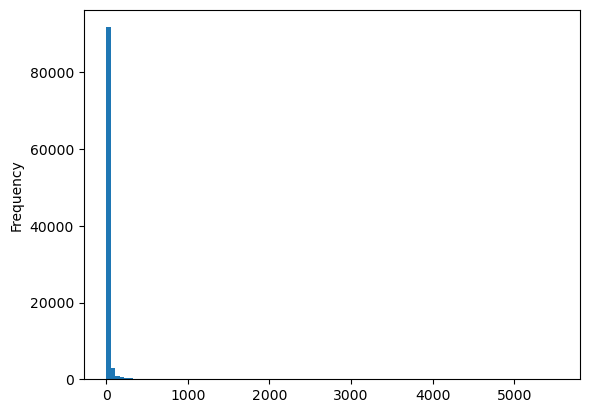

In [24]:
df['Score_Q'].plot(kind='hist',
                          bins=100)

<AxesSubplot:ylabel='Frequency'>

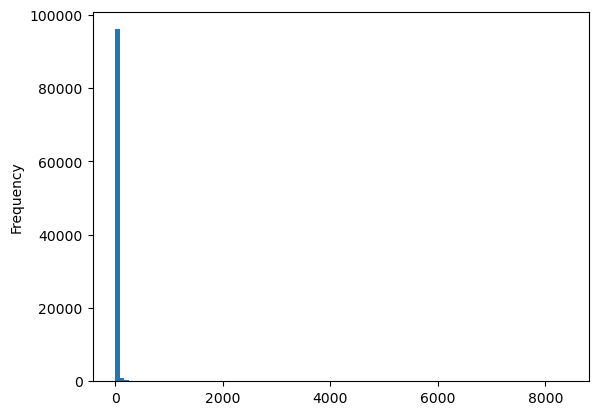

In [25]:
df['Score_A'].plot(kind='hist',
                        bins=100)

df['Body'].replace(['<p>','</p>','\n','<ul>','<li>','</li>','</ul>'],'',regex=True)[0]

In [29]:
comment_words = ''
for index in range(len(df)):
    val = str(df['Body_Q'][index])
    if(index%10000==0):
        print(index)
    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [32]:
word_cloud = WordCloud(width=800,height=800,
                        background_color='white',
                        stopwords=stop_list,
                        min_font_size=10).generate(comment_words)

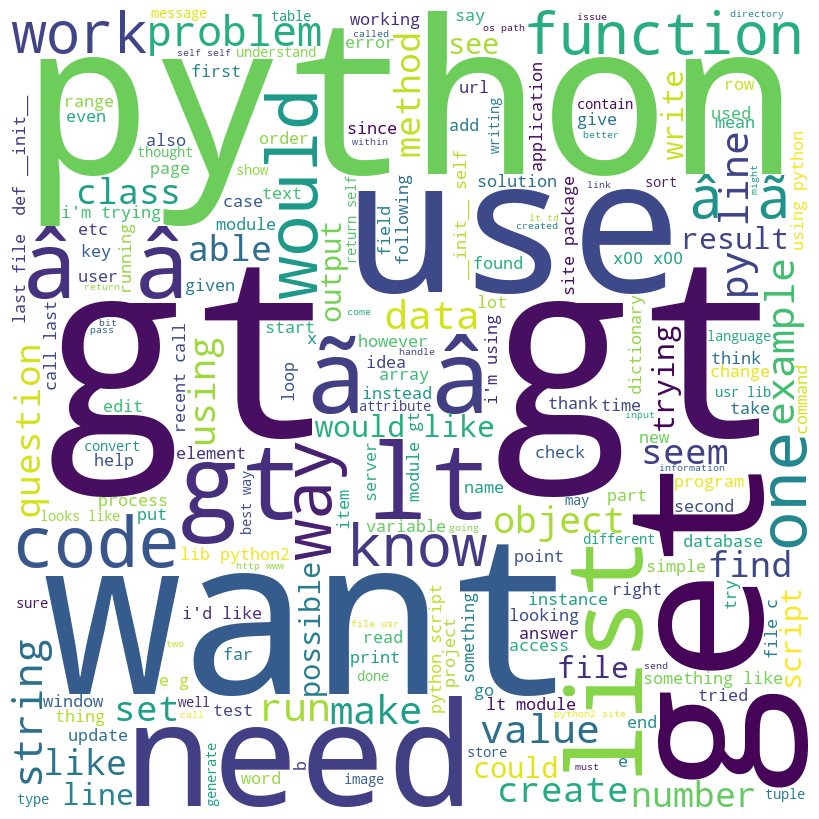

In [33]:
plt.figure(figsize=(8, 8),facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Model Training

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df['Body_Q'],df['Body_A'], test_size=0.2)

In [35]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

2023-10-22 21:18:22.583 INFO    absl: Using C:\Users\michael\AppData\Local\Temp\tfhub_modules to cache modules.
2023-10-22 21:18:22.593 INFO    absl: Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
2023-10-22 21:18:23.760 INFO    absl: Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
2023-10-22 21:18:23.773 INFO    absl: Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.


In [36]:
corpus_train = X_train
tokenized_corpus_train = [sentence.lower().split() for sentence in corpus_train]

In [37]:
corpus_test = X_test
tokenized_corpus_test = [sentence.lower().split() for sentence in corpus_test]

In [38]:
word2vec_model = models.Word2Vec(tokenized_corpus_train, vector_size=100, window=5, min_count=1, sg=0)

2023-10-22 21:18:40.377 INFO    gensim.models.word2vec: collecting all words and their counts
2023-10-22 21:18:40.378 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-10-22 21:18:40.667 INFO    gensim.models.word2vec: PROGRESS: at sentence #10000, processed 1226993 words, keeping 119120 word types
2023-10-22 21:18:40.956 INFO    gensim.models.word2vec: PROGRESS: at sentence #20000, processed 2447508 words, keeping 188762 word types
2023-10-22 21:18:41.223 INFO    gensim.models.word2vec: PROGRESS: at sentence #30000, processed 3668752 words, keeping 242022 word types
2023-10-22 21:18:41.508 INFO    gensim.models.word2vec: PROGRESS: at sentence #40000, processed 4871497 words, keeping 280195 word types
2023-10-22 21:18:41.774 INFO    gensim.models.word2vec: PROGRESS: at sentence #50000, processed 6089680 words, keeping 312306 word types
2023-10-22 21:18:42.051 INFO    gensim.models.word2vec: PROGRESS: at sentence #60000, processed 730

2023-10-22 21:19:17.204 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 11.99% examples, 908734 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:18.193 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 24.02% examples, 912068 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:19.196 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 36.17% examples, 912003 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:20.219 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 48.35% examples, 909670 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:21.211 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 60.83% examples, 915977 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:22.235 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 73.10% examples, 917085 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:23.246 INFO    gensim.models.word2vec: EPOCH 4 - PROGRESS: at 85.54% examples, 917077 words/s, in_qsize 5, out_qsize 0
2023-10-22 21:19:24.247 INFO    gensim.models.wo

In [39]:
word2vec_model.build_vocab(tokenized_corpus_train,progress_per=100)

2023-10-22 21:19:32.790 INFO    gensim.models.word2vec: collecting all words and their counts
2023-10-22 21:19:32.791 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-10-22 21:19:32.795 INFO    gensim.models.word2vec: PROGRESS: at sentence #100, processed 12300 words, keeping 3758 word types
2023-10-22 21:19:32.799 INFO    gensim.models.word2vec: PROGRESS: at sentence #200, processed 26269 words, keeping 6533 word types
2023-10-22 21:19:32.803 INFO    gensim.models.word2vec: PROGRESS: at sentence #300, processed 40308 words, keeping 9170 word types
2023-10-22 21:19:32.805 INFO    gensim.models.word2vec: PROGRESS: at sentence #400, processed 54165 words, keeping 11540 word types
2023-10-22 21:19:32.805 INFO    gensim.models.word2vec: PROGRESS: at sentence #500, processed 63925 words, keeping 13203 word types
2023-10-22 21:19:32.815 INFO    gensim.models.word2vec: PROGRESS: at sentence #600, processed 75698 words, keeping 15089 word t

2023-10-22 21:19:33.099 INFO    gensim.models.word2vec: PROGRESS: at sentence #6100, processed 751942 words, keeping 83611 word types
2023-10-22 21:19:33.105 INFO    gensim.models.word2vec: PROGRESS: at sentence #6200, processed 763396 words, keeping 84581 word types
2023-10-22 21:19:33.105 INFO    gensim.models.word2vec: PROGRESS: at sentence #6300, processed 775862 words, keeping 85473 word types
2023-10-22 21:19:33.105 INFO    gensim.models.word2vec: PROGRESS: at sentence #6400, processed 788688 words, keeping 86599 word types
2023-10-22 21:19:33.121 INFO    gensim.models.word2vec: PROGRESS: at sentence #6500, processed 800204 words, keeping 87420 word types
2023-10-22 21:19:33.123 INFO    gensim.models.word2vec: PROGRESS: at sentence #6600, processed 812380 words, keeping 88415 word types
2023-10-22 21:19:33.123 INFO    gensim.models.word2vec: PROGRESS: at sentence #6700, processed 822406 words, keeping 89126 word types
2023-10-22 21:19:33.132 INFO    gensim.models.word2vec: PROGRE

2023-10-22 21:19:33.387 INFO    gensim.models.word2vec: PROGRESS: at sentence #12200, processed 1501192 words, keeping 136686 word types
2023-10-22 21:19:33.389 INFO    gensim.models.word2vec: PROGRESS: at sentence #12300, processed 1513306 words, keeping 137298 word types
2023-10-22 21:19:33.389 INFO    gensim.models.word2vec: PROGRESS: at sentence #12400, processed 1526702 words, keeping 138454 word types
2023-10-22 21:19:33.402 INFO    gensim.models.word2vec: PROGRESS: at sentence #12500, processed 1540893 words, keeping 139140 word types
2023-10-22 21:19:33.407 INFO    gensim.models.word2vec: PROGRESS: at sentence #12600, processed 1552423 words, keeping 139804 word types
2023-10-22 21:19:33.407 INFO    gensim.models.word2vec: PROGRESS: at sentence #12700, processed 1563614 words, keeping 140400 word types
2023-10-22 21:19:33.415 INFO    gensim.models.word2vec: PROGRESS: at sentence #12800, processed 1574714 words, keeping 140950 word types
2023-10-22 21:19:33.421 INFO    gensim.mo

2023-10-22 21:19:33.653 INFO    gensim.models.word2vec: PROGRESS: at sentence #18200, processed 2237932 words, keeping 178981 word types
2023-10-22 21:19:33.654 INFO    gensim.models.word2vec: PROGRESS: at sentence #18300, processed 2249058 words, keeping 179481 word types
2023-10-22 21:19:33.654 INFO    gensim.models.word2vec: PROGRESS: at sentence #18400, processed 2261641 words, keeping 179945 word types
2023-10-22 21:19:33.654 INFO    gensim.models.word2vec: PROGRESS: at sentence #18500, processed 2273251 words, keeping 180653 word types
2023-10-22 21:19:33.667 INFO    gensim.models.word2vec: PROGRESS: at sentence #18600, processed 2284359 words, keeping 181262 word types
2023-10-22 21:19:33.672 INFO    gensim.models.word2vec: PROGRESS: at sentence #18700, processed 2296274 words, keeping 181791 word types
2023-10-22 21:19:33.672 INFO    gensim.models.word2vec: PROGRESS: at sentence #18800, processed 2307308 words, keeping 182228 word types
2023-10-22 21:19:33.672 INFO    gensim.mo

2023-10-22 21:19:33.902 INFO    gensim.models.word2vec: PROGRESS: at sentence #24200, processed 2956950 words, keeping 213250 word types
2023-10-22 21:19:33.905 INFO    gensim.models.word2vec: PROGRESS: at sentence #24300, processed 2968998 words, keeping 213660 word types
2023-10-22 21:19:33.905 INFO    gensim.models.word2vec: PROGRESS: at sentence #24400, processed 2981442 words, keeping 214047 word types
2023-10-22 21:19:33.905 INFO    gensim.models.word2vec: PROGRESS: at sentence #24500, processed 2994295 words, keeping 214644 word types
2023-10-22 21:19:33.919 INFO    gensim.models.word2vec: PROGRESS: at sentence #24600, processed 3005896 words, keeping 215091 word types
2023-10-22 21:19:33.923 INFO    gensim.models.word2vec: PROGRESS: at sentence #24700, processed 3019604 words, keeping 215844 word types
2023-10-22 21:19:33.923 INFO    gensim.models.word2vec: PROGRESS: at sentence #24800, processed 3031818 words, keeping 216538 word types
2023-10-22 21:19:33.923 INFO    gensim.mo

2023-10-22 21:19:34.155 INFO    gensim.models.word2vec: PROGRESS: at sentence #30200, processed 3692562 words, keeping 242793 word types
2023-10-22 21:19:34.155 INFO    gensim.models.word2vec: PROGRESS: at sentence #30300, processed 3704557 words, keeping 243174 word types
2023-10-22 21:19:34.167 INFO    gensim.models.word2vec: PROGRESS: at sentence #30400, processed 3717191 words, keeping 243565 word types
2023-10-22 21:19:34.171 INFO    gensim.models.word2vec: PROGRESS: at sentence #30500, processed 3727079 words, keeping 244031 word types
2023-10-22 21:19:34.172 INFO    gensim.models.word2vec: PROGRESS: at sentence #30600, processed 3738110 words, keeping 244311 word types
2023-10-22 21:19:34.172 INFO    gensim.models.word2vec: PROGRESS: at sentence #30700, processed 3751385 words, keeping 244870 word types
2023-10-22 21:19:34.183 INFO    gensim.models.word2vec: PROGRESS: at sentence #30800, processed 3764836 words, keeping 245368 word types
2023-10-22 21:19:34.187 INFO    gensim.mo

2023-10-22 21:19:34.423 INFO    gensim.models.word2vec: PROGRESS: at sentence #36200, processed 4415777 words, keeping 267003 word types
2023-10-22 21:19:34.423 INFO    gensim.models.word2vec: PROGRESS: at sentence #36300, processed 4429580 words, keeping 267401 word types
2023-10-22 21:19:34.432 INFO    gensim.models.word2vec: PROGRESS: at sentence #36400, processed 4440835 words, keeping 267900 word types
2023-10-22 21:19:34.436 INFO    gensim.models.word2vec: PROGRESS: at sentence #36500, processed 4452553 words, keeping 268285 word types
2023-10-22 21:19:34.439 INFO    gensim.models.word2vec: PROGRESS: at sentence #36600, processed 4462440 words, keeping 268560 word types
2023-10-22 21:19:34.439 INFO    gensim.models.word2vec: PROGRESS: at sentence #36700, processed 4473453 words, keeping 269104 word types
2023-10-22 21:19:34.439 INFO    gensim.models.word2vec: PROGRESS: at sentence #36800, processed 4483846 words, keeping 269390 word types
2023-10-22 21:19:34.452 INFO    gensim.mo

2023-10-22 21:19:34.672 INFO    gensim.models.word2vec: PROGRESS: at sentence #42200, processed 5138034 words, keeping 288011 word types
2023-10-22 21:19:34.672 INFO    gensim.models.word2vec: PROGRESS: at sentence #42300, processed 5150631 words, keeping 288408 word types
2023-10-22 21:19:34.682 INFO    gensim.models.word2vec: PROGRESS: at sentence #42400, processed 5162238 words, keeping 288659 word types
2023-10-22 21:19:34.686 INFO    gensim.models.word2vec: PROGRESS: at sentence #42500, processed 5173838 words, keeping 288923 word types
2023-10-22 21:19:34.689 INFO    gensim.models.word2vec: PROGRESS: at sentence #42600, processed 5185185 words, keeping 289174 word types
2023-10-22 21:19:34.689 INFO    gensim.models.word2vec: PROGRESS: at sentence #42700, processed 5199026 words, keeping 289603 word types
2023-10-22 21:19:34.699 INFO    gensim.models.word2vec: PROGRESS: at sentence #42800, processed 5211171 words, keeping 289963 word types
2023-10-22 21:19:34.703 INFO    gensim.mo

2023-10-22 21:19:34.922 INFO    gensim.models.word2vec: PROGRESS: at sentence #48200, processed 5873313 words, keeping 307285 word types
2023-10-22 21:19:34.935 INFO    gensim.models.word2vec: PROGRESS: at sentence #48300, processed 5886779 words, keeping 307648 word types
2023-10-22 21:19:34.938 INFO    gensim.models.word2vec: PROGRESS: at sentence #48400, processed 5897875 words, keeping 307894 word types
2023-10-22 21:19:34.939 INFO    gensim.models.word2vec: PROGRESS: at sentence #48500, processed 5909431 words, keeping 308117 word types
2023-10-22 21:19:34.939 INFO    gensim.models.word2vec: PROGRESS: at sentence #48600, processed 5920494 words, keeping 308331 word types
2023-10-22 21:19:34.949 INFO    gensim.models.word2vec: PROGRESS: at sentence #48700, processed 5931426 words, keeping 308546 word types
2023-10-22 21:19:34.954 INFO    gensim.models.word2vec: PROGRESS: at sentence #48800, processed 5942844 words, keeping 308864 word types
2023-10-22 21:19:34.954 INFO    gensim.mo

2023-10-22 21:19:35.188 INFO    gensim.models.word2vec: PROGRESS: at sentence #54200, processed 6597004 words, keeping 323253 word types
2023-10-22 21:19:35.188 INFO    gensim.models.word2vec: PROGRESS: at sentence #54300, processed 6609528 words, keeping 323845 word types
2023-10-22 21:19:35.203 INFO    gensim.models.word2vec: PROGRESS: at sentence #54400, processed 6620485 words, keeping 324025 word types
2023-10-22 21:19:35.205 INFO    gensim.models.word2vec: PROGRESS: at sentence #54500, processed 6632396 words, keeping 324185 word types
2023-10-22 21:19:35.205 INFO    gensim.models.word2vec: PROGRESS: at sentence #54600, processed 6644750 words, keeping 324508 word types
2023-10-22 21:19:35.205 INFO    gensim.models.word2vec: PROGRESS: at sentence #54700, processed 6655029 words, keeping 324682 word types
2023-10-22 21:19:35.221 INFO    gensim.models.word2vec: PROGRESS: at sentence #54800, processed 6667891 words, keeping 325160 word types
2023-10-22 21:19:35.221 INFO    gensim.mo

2023-10-22 21:19:35.455 INFO    gensim.models.word2vec: PROGRESS: at sentence #60200, processed 7327992 words, keeping 338647 word types
2023-10-22 21:19:35.455 INFO    gensim.models.word2vec: PROGRESS: at sentence #60300, processed 7340006 words, keeping 338941 word types
2023-10-22 21:19:35.470 INFO    gensim.models.word2vec: PROGRESS: at sentence #60400, processed 7353178 words, keeping 339164 word types
2023-10-22 21:19:35.472 INFO    gensim.models.word2vec: PROGRESS: at sentence #60500, processed 7364628 words, keeping 339505 word types
2023-10-22 21:19:35.472 INFO    gensim.models.word2vec: PROGRESS: at sentence #60600, processed 7376116 words, keeping 339687 word types
2023-10-22 21:19:35.483 INFO    gensim.models.word2vec: PROGRESS: at sentence #60700, processed 7388326 words, keeping 339858 word types
2023-10-22 21:19:35.487 INFO    gensim.models.word2vec: PROGRESS: at sentence #60800, processed 7400059 words, keeping 340039 word types
2023-10-22 21:19:35.487 INFO    gensim.mo

2023-10-22 21:19:35.722 INFO    gensim.models.word2vec: PROGRESS: at sentence #66200, processed 8053700 words, keeping 350908 word types
2023-10-22 21:19:35.722 INFO    gensim.models.word2vec: PROGRESS: at sentence #66300, processed 8067373 words, keeping 351081 word types
2023-10-22 21:19:35.735 INFO    gensim.models.word2vec: PROGRESS: at sentence #66400, processed 8081351 words, keeping 351219 word types
2023-10-22 21:19:35.739 INFO    gensim.models.word2vec: PROGRESS: at sentence #66500, processed 8092956 words, keeping 351429 word types
2023-10-22 21:19:35.739 INFO    gensim.models.word2vec: PROGRESS: at sentence #66600, processed 8104592 words, keeping 351722 word types
2023-10-22 21:19:35.739 INFO    gensim.models.word2vec: PROGRESS: at sentence #66700, processed 8117639 words, keeping 351917 word types
2023-10-22 21:19:35.752 INFO    gensim.models.word2vec: PROGRESS: at sentence #66800, processed 8128684 words, keeping 352194 word types
2023-10-22 21:19:35.754 INFO    gensim.mo

2023-10-22 21:19:35.986 INFO    gensim.models.word2vec: PROGRESS: at sentence #72200, processed 8784208 words, keeping 362449 word types
2023-10-22 21:19:36.006 INFO    gensim.models.word2vec: PROGRESS: at sentence #72300, processed 8795209 words, keeping 362707 word types
2023-10-22 21:19:36.017 INFO    gensim.models.word2vec: PROGRESS: at sentence #72400, processed 8806587 words, keeping 362944 word types
2023-10-22 21:19:36.022 INFO    gensim.models.word2vec: PROGRESS: at sentence #72500, processed 8816757 words, keeping 363108 word types
2023-10-22 21:19:36.027 INFO    gensim.models.word2vec: PROGRESS: at sentence #72600, processed 8829953 words, keeping 363398 word types
2023-10-22 21:19:36.030 INFO    gensim.models.word2vec: PROGRESS: at sentence #72700, processed 8842451 words, keeping 363692 word types
2023-10-22 21:19:36.034 INFO    gensim.models.word2vec: PROGRESS: at sentence #72800, processed 8853875 words, keeping 363773 word types
2023-10-22 21:19:36.038 INFO    gensim.mo

2023-10-22 21:19:36.256 INFO    gensim.models.word2vec: Creating a fresh vocabulary
2023-10-22 21:19:38.143 INFO    gensim.utils: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 372435 unique words (100.0%% of original 372435, drops 0)', 'datetime': '2023-10-22T21:19:38.143981', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-10-22 21:19:38.143 INFO    gensim.utils: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 9480091 word corpus (100.0%% of original 9480091, drops 0)', 'datetime': '2023-10-22T21:19:38.143981', 'gensim': '4.1.2', 'python': '3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2023-10-22 21:19:40.934 INFO    gensim.models.word2vec: deleting the raw counts dictionary of 372435 items
2023-10-22 21:19:40.949 INFO    gensim.models.word2vec: s

In [40]:
text_preprocessed = bert_preprocess_model(X_train)
text_preprocessed.keys()

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

In [41]:
text_preprocessed

{'input_word_ids': <tf.Tensor: shape=(78043, 128), dtype=int32, numpy=
 array([[  101,  1999, 18750, ...,     0,     0,     0],
        [  101,  1045,  1005, ...,  1006,  1005,   102],
        [  101,  2129,  5149, ...,  2000,  1013,   102],
        ...,
        [  101,  1045,  1005, ...,  1012,  1996,   102],
        [  101,  1045,  2001, ...,  4563, 12324,   102],
        [  101,  1045,  1005, ...,  2258,  1004,   102]])>,
 'input_mask': <tf.Tensor: shape=(78043, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])>,
 'input_type_ids': <tf.Tensor: shape=(78043, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>}

In [42]:
bert_model = hub.KerasLayer(encoder_url)

In [43]:
bert_results = bert_model(text_preprocessed)

ResourceExhaustedError: Exception encountered when calling layer "keras_layer_1" "                 f"(type KerasLayer).

Graph execution error:

OOM when allocating tensor with shape[9989504,768] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node word_embeddings/Gather}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_restored_function_body_52729]

Call arguments received by layer "keras_layer_1" "                 f"(type KerasLayer):
  • inputs={'input_word_ids': 'tf.Tensor(shape=(78043, 128), dtype=int32)', 'input_mask': 'tf.Tensor(shape=(78043, 128), dtype=int32)', 'input_type_ids': 'tf.Tensor(shape=(78043, 128), dtype=int32)'}
  • training=None

In [44]:
bert_results.keys()

NameError: name 'bert_results' is not defined

In [ ]:
bert_results

In [45]:
df['Body_Q'][0]

"I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of: Some Photoshop javascript A Python function An OSX API that I can call from python"

In [46]:
df['Body_A'][0]

'open up a terminal (Applications-&gt;Utilities-&gt;Terminal) and type this in: locate InsertFontHere This will spit out every file that has the name you want. Warning: there may be alot to wade through.'

In [47]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

In [ ]:
while True:
    question = str(input("Ask a question (type 'exit' to quit): "))
    if(question.lower() in ['exit','done','none','goodbye','bye','finished']):
        break
    print(generate_word2vec_answer(question, df['Body_A'], word2vec_model))
    generated_answers = generate_answers(question, df, model, tokenizer, n=5)
    for i, answer in enumerate(generated_answers):
        print(f"Answer {i + 1}: {answer}\n")

Ask a question (type 'exit' to quit): I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of: Some Photoshop javascript A Python function An OSX API that I can call from python
36741
Yo can do that to reproduce the same behavior that your example in Java. # Some list example = {} # or example = dict() ... # Index into data estructure. example[example.keys(i)] # Check for some string... if example[example.keys(i)] == 'someText' : pass # Store in some other variable... exam = example[example.keys(i)] del example[example.keys(i)] # ...or exam = example.pop(example.keys(i))
[array([1.        , 1.        , 1.        , ..., 0.02151032, 0.03607844,
       0.04964591])]
[    0     1     2 ... 19205 25435 49936]
Answer 1: open up a terminal (Applications-

In [ ]:
st.header("BERT Question and Answer")
st.write("""
         Ask any question and I will give you 5 possible answers.
         """)


In [ ]:
user_question = st.text_input("")
generated_answers = generate_answers(user_question, df, model, tokenizer, n=5)
st.write(generated_answers)